# Treeline
### (the ROOT equivalent of a *pipeline*)

In the big picture, we don't have too much data and this doesn't need to be too automated. I've been focussed a lot on figuring out how to deal with the TTree format more efficiently, but that might not be the best way to go about it. Trying just to go w/ straightforward **slices** and iteration

In [64]:
# imports, all in one place for ease of running
# apart from this, each sub-heading (e.g. Position, Calculating energy…) should be self-contained
# i.e. we import libraries and ROOT file here 

from ROOT import TFile, TProfile, TCanvas, TH1D, TH2D
import numpy as np
from scipy import stats, optimize
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import math
from array import array

#For our rectangles
from matplotlib import cm
from matplotlib.patches import Rectangle

#File
'''Bonus: ID	Beam Energy	Beam Type	Magnet Energy	Eudaq	TDaq	Scintillator Thickness	Most Recent Alignment Run (EUDAQ)	All micromegas? y/n
736	1	Positron	100	320	1572192942	0.2	295	y'''
importFile = TFile("/nfs/dust/fhlabs/group/BL4S/data/DESYChain/ConvertedData/1572098569.root", "READ")
RECOdata=importFile.Get("RECOdata")

importFile_alignment = TFile("/nfs/dust/fhlabs/group/BL4S/data/DESYChain/ConvertedData/1572083953.root", "READ")
RECO_alignment = importFile_alignment.Get("RECOdata")

#Helpful dictionaries/lists
detector_list = ['Mimosa0_xPosition', 'Mimosa0_yPosition', 'Mimosa1_xPosition', 'Mimosa1_yPosition',
                'Mimosa2_xPosition', 'Mimosa2_yPosition', 'DWC0_xPosition', 'DWC0_yPosition',
                'Chamber1_position', 'Chamber2_position', 'Chamber3_position'] #ordered front->back
detector_xy_list = [('Mimosa0_xPosition', 'Mimosa0_yPosition'), ('Mimosa1_xPosition', 'Mimosa1_yPosition'),
                    ('Mimosa2_xPosition', 'Mimosa2_yPosition'), ('DWC0_xPosition', 'DWC0_yPosition'),
                    ('Chamber2_position', 'Chamber3_position')]
detector_alignment_dict = {'mimosa0y': 'Mimosa0_yPosition', 'mimosa0x': 'Mimosa0_xPosition', 
                           'mimosa1x': 'Mimosa1_xPosition', 'mimosa1y': 'Mimosa1_yPosition',
                           'mimosa2x': 'Mimosa2_xPosition', 'mimosa2y': 'Mimosa2_yPosition', 
                           'dwc0x': 'DWC0_xPosition', 'dwc0y': 'DWC0_yPosition',
                           'micromega1x': 'Chamber1_position', 'micromega2x': 'Chamber2_position',
                           'micromega3y': 'Chamber3_position'}
detcector_z_dict = {'Chamber1_position': 345, 'Chamber2_position': 533, 'Chamber3_position': 577,
                    'Mimosa0_xPosition': 67.5, 'Mimosa0_yPosition': 67.5, 'Mimosa1_xPosition': 75,
                    'Mimosa1_yPosition': 75, 'Mimosa2_xPosition': 83, 'Mimosa2_yPosition': 83,
                    'DWC0_xPosition': 304, 'DWC0_yPosition': 304}

### Position
Confirming the alignment runs, and looking at the range of their distributions

'with open(\'../Alignment/alignment478.txt\', \'w\') as out_file:\n    for detector in detector_means:\n        out_file.write(f"{detector_output_alignment_dict[detector]}: {detector_means[detector]}\n")'

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Alignment plots
Warning in <TFile::Append>: Replacing existing TH1: name (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: name (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: name (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: name (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: name (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: name (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: name (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: name (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: name (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: name (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: name (Potential memory leak).


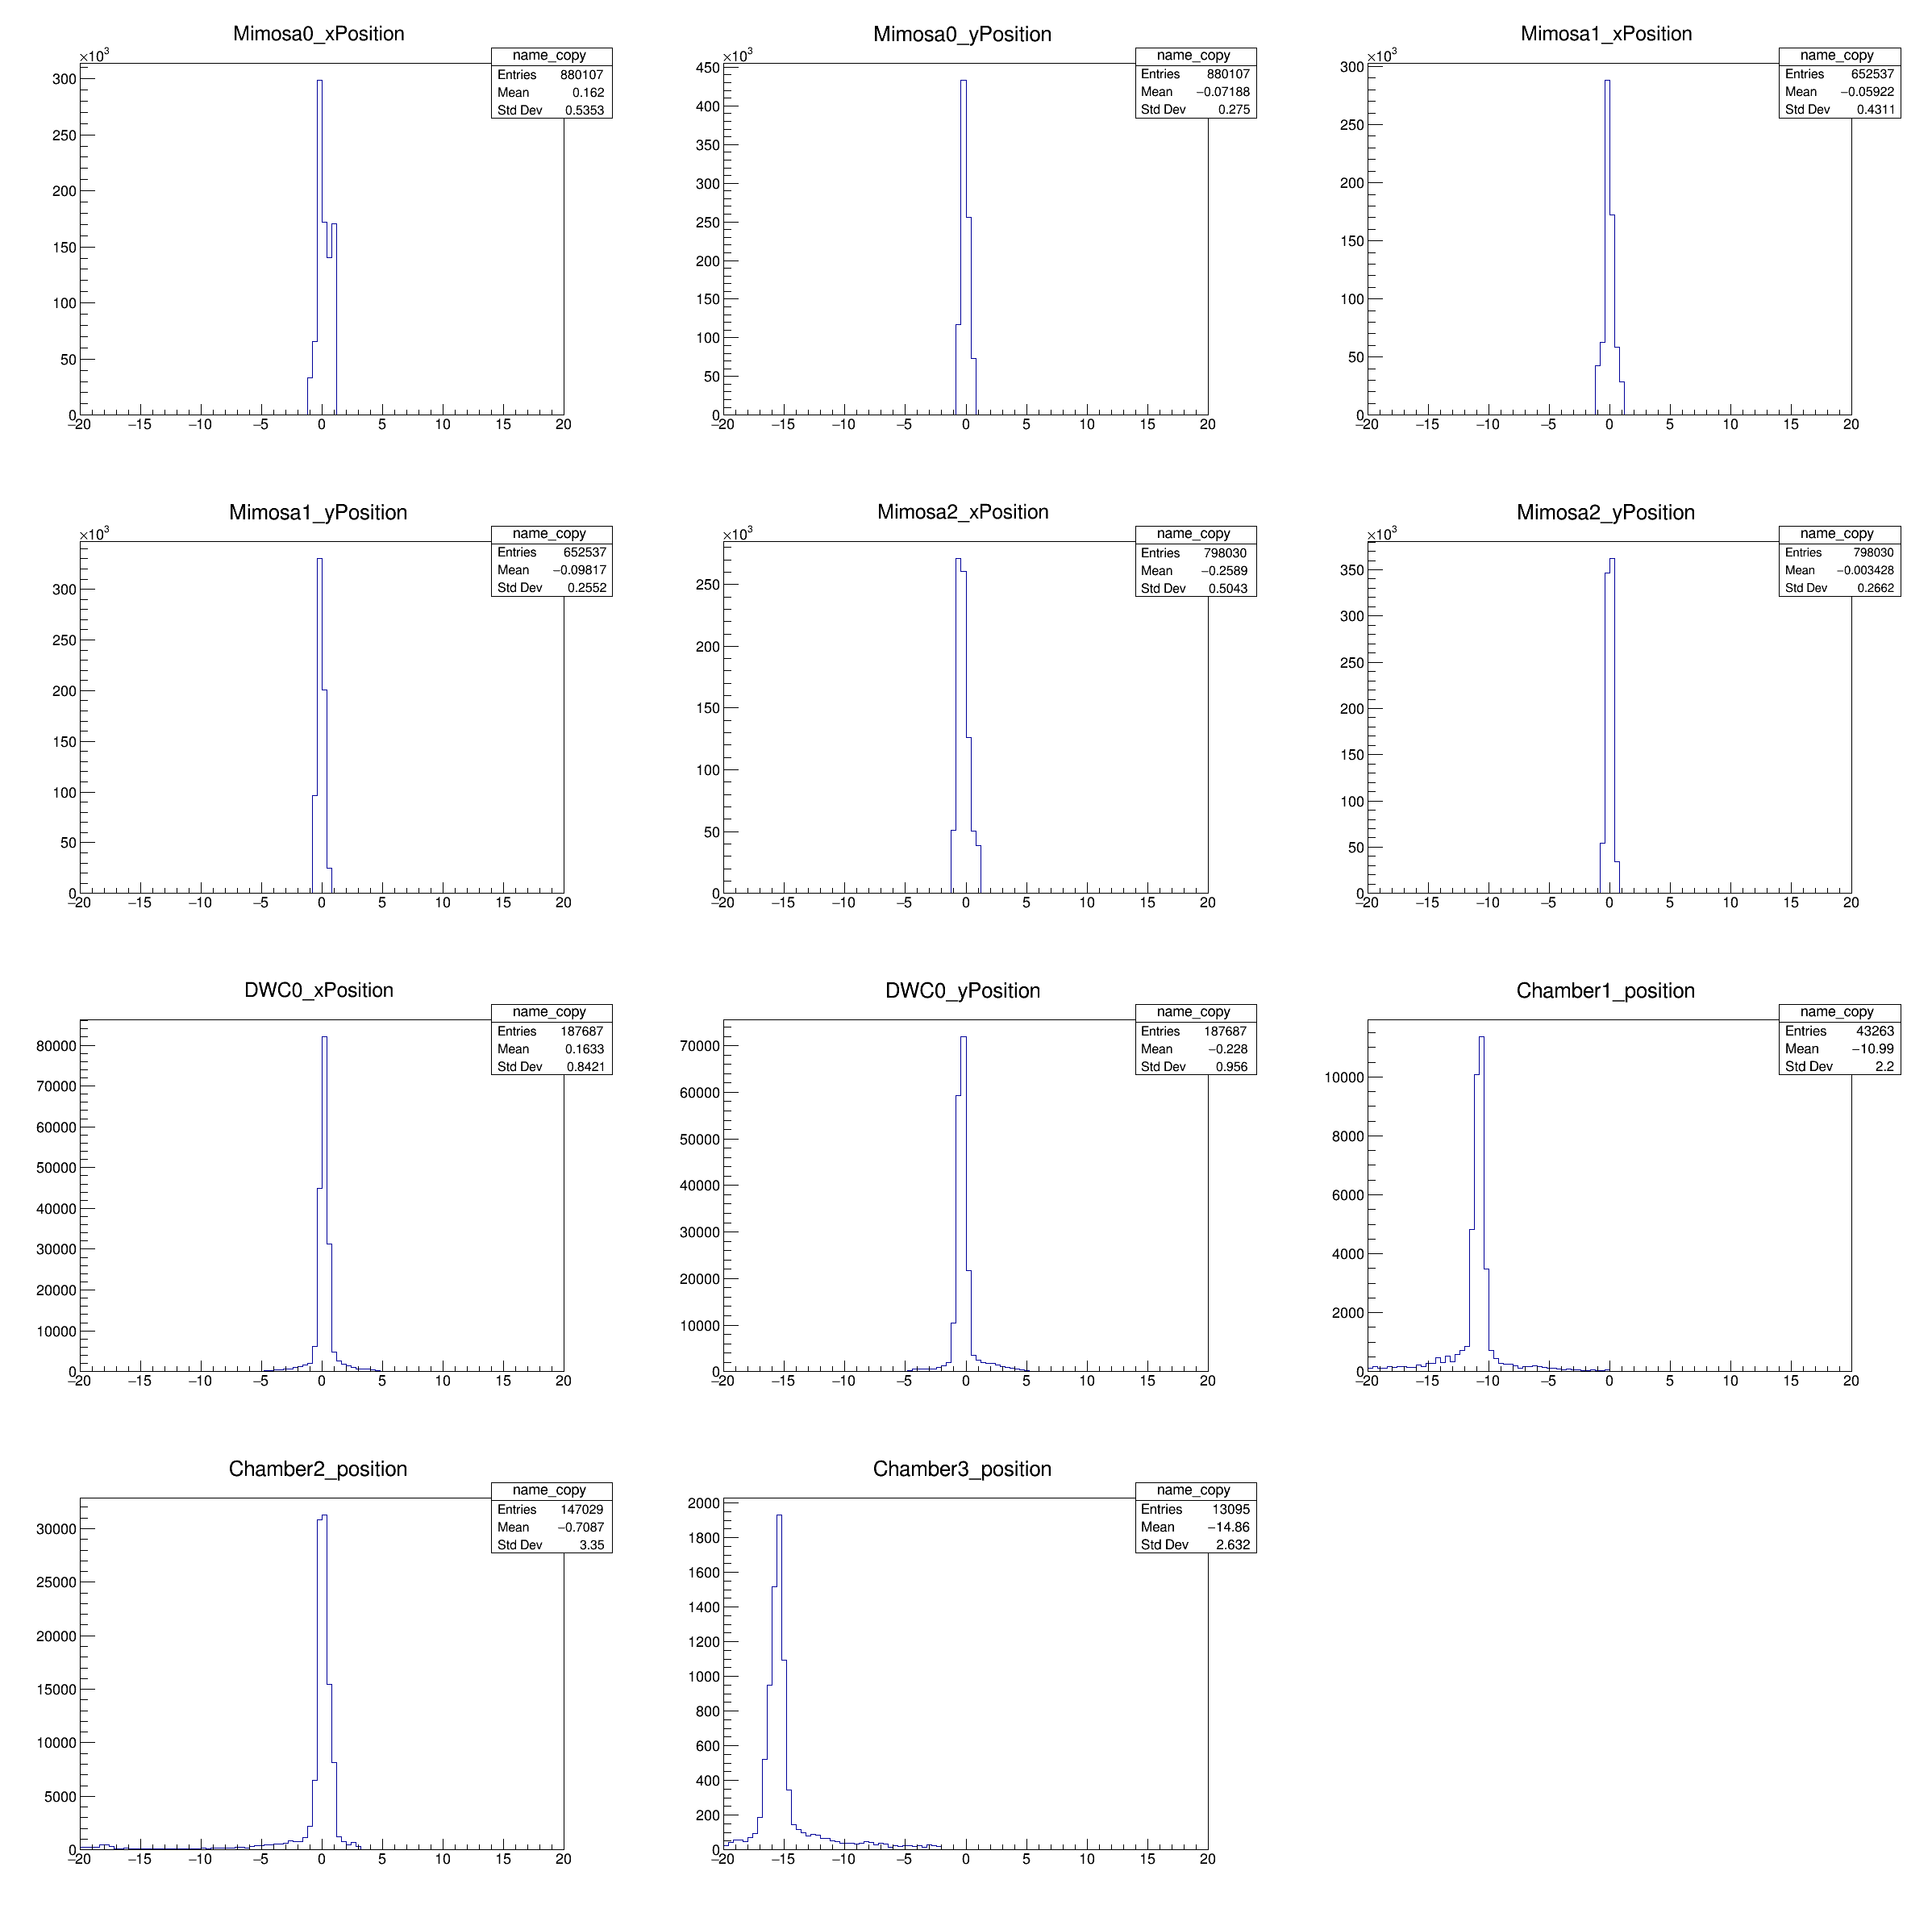

In [52]:
# Getting alignment data from 1572083953 (run 478/479)
# Graphing all detectors to look for weird behaviour:
detector_output_alignment_dict = {v:k for k, v in detector_alignment_dict.items()}

c1=TCanvas("Alignment plots", "Alignment plots", 2400, 2400)
c1.Divide(3, 4)
detector_means = dict()
for index, detector in enumerate(detector_list):
    c1.cd(index + 1)
    hist1=TH1D("name", detector, 100, -20, 20)
    if detector == 'Chamber2_position': #seems to have noise ~5
        RECO_alignment.Draw(f"{detector}>>name", f"{detector} < 3")
    elif detector == 'Chamber3_position': #seems to have noise ~0
        RECO_alignment.Draw(f"{detector}>>name", f"{detector} < -2")
    else:
        RECO_alignment.Draw(f"{detector}>>name")
    hist1.DrawCopy() #since it's all the same histogram, if we just Draw() it will erase the old one
    detector_means[detector] = -hist1.GetMean() #putting the offset we need to *add back*
c1.Draw()

# And writing to file
with open('../Alignment/alignment478.txt', 'w') as out_file:
    for detector in detector_means:
        out_file.write(f"{detector_output_alignment_dict[detector]}: {detector_means[detector]}\n")

In [56]:
def read_alignment_file(filepath):
    return_offsets = dict()
    with open(filepath, 'r') as alignment_file:
        for line in alignment_file:
            line_split = line.split(':')
            return_offsets[detector_alignment_dict[line_split[0]]] = float(line_split[1])
    return return_offsets

offsets = read_alignment_file('../Alignment/alignment478.txt')

for detector in detector_list:
    q_hist = TH1D("qhist", "title", 1000, -20, 20)
    RECO_alignment.Draw(f"{detector}>>qhist")
    print(detector, q_hist.GetMean(), q_hist.GetMean() + offsets[detector])

Mimosa0_xPosition 0.16200300477374738 0.0
Mimosa0_yPosition -0.07188037854438818 0.0
Mimosa1_xPosition -0.05921837693965215 0.0
Mimosa1_yPosition -0.09816501082135087 0.0
Mimosa2_xPosition -0.25891844948327086 0.0
Mimosa2_yPosition -0.0034275123029394207 0.0
DWC0_xPosition 0.16333889490991782 0.0
DWC0_yPosition -0.22804878290973482 0.0
Chamber1_position -10.990702845870967 0.0
Chamber2_position 0.6024681734985246 1.311129196050743
Chamber3_position -11.912956365811167 2.942131464727275


Warning in <TFile::Append>: Replacing existing TH1: qhist (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: qhist (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: qhist (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: qhist (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: qhist (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: qhist (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: qhist (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: qhist (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: qhist (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: qhist (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: qhist (Potential memory leak).


Now using August and Charlie's normalized x-y positions, to plot for different detectors

Mimosa0_xPosition Mimosa0_yPosition [-0.4876830047737474] [-0.0905653357413261] True
Mimosa1_xPosition Mimosa1_yPosition [0.053698376939652154] [-0.13367498917864915] True
Mimosa2_xPosition Mimosa2_yPosition [-0.5083615505167292] [0.2720675123029394] True
DWC0_xPosition DWC0_yPosition [0.14560686053944927] [-2.4538722908368737] True
Chamber2_position Chamber3_position [12.829883489512572] [9.720202345707985] True


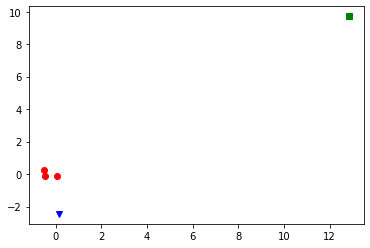

In [76]:
# We have to remember carefully that the MMs (Chamber 1-3) are 1-D. 
# To be specifc, MMs 1 & 2 give x-position and MM 3 gives y-position

closest_alignment = 478 #<-
offsets = read_alignment_file(f'../Alignment/alignment{478}.txt')

for num, event in enumerate(RECOdata):
    if all([bool(getattr(event, dect)) for dect in detector_list]):
        for x_dect, y_dect in detector_xy_list:
            x_points = list(getattr(event, x_dect))[0:min(len(x_points), len(y_points))] #for MMs, they may have different dimensions
            x_points = [x + offsets[x_dect] for x in x_points]
            y_points = list(getattr(event, y_dect))[0:min(len(x_points), len(y_points))]
            y_points = [y + offsets[y_dect] for y in y_points]
            if "Mimosa" in x_dect:
                formt = 'ro'
            elif "DWC" in x_dect:
                formt = 'bv'
            else:
                formt = 'gs'
            plt.plot(x_points, y_points, formt)
            print(x_dect, y_dect, x_points, y_points, bool(getattr(event, x_dect)))
        break
plt.show()

#### And now using z-positions

In [ ]:
# Copying from run 66 the z-positions "±1cm"
# Note that Mimosas are "±0.1cm"
''' stuff that isn't detectors
Beam exit point of collimator: -21 cm 
Concrete stand for the collimator = 0 cm
Trigger scintillators begin at 42 cm
From front of trigger scintillators to front of black box: 4 cm
    Black box length: 12.5 cm
Front of BRM: 114 cm
Back of BRM: 273 cm
'''

# order the z-dict (using a seperate list) back->front, if desired
# plotting x-y, x-z, y-z, and x-y-z

### Exluding noisy pixels, and noisy events

### Excluding events with multiple tracks (outliers!)

### Calculating energy by magnet deflection

#### Finding $\theta$ by fitting a linear model

When we have sufficient points to fit a true line to the post-BRM particle, it is easy to calculate $\theta$
$$ \cos\theta = \frac{\vec{a}\cdot\vec{b}}{\left\lVert\vec{a}\right\rVert\left\lVert\vec{b}\right\rVert} $$
![](img/line.png)
However, while we shouldn't use it for actual data (probably), we can calculate angle deflected from just one point (i.e. the DWC), using the assumption that the particle bends at a constant angle during its time in the BRM — each point on the other side of the magnet corresponds uniquely to a $\frac{d\theta}{dt}$.
![](img/single_point.png)
Under this assumption, if we let the point the particle enters the BRM as $(x, z) = (0, 0, 0)$, it follows a path described by the partial circle centered at $(r, 0, 0)$
$$ z = \sqrt{r^2 - (x - r)^2}$$
where the radius of this path (corresponding to the energy) is our unknown. Let the point it exits the BRM be $(x_e, z_e)$ and where it impacts the DWC be $(x_p, z_p)$. When it exits the BRM, it follows a path given by $\frac{dz}{dx}$. We know, however, $z_e$, so we can calculate 
$$ x = -\sqrt{r^2 - z^2} + r \implies \frac{dx}{dz} = \frac{z}{\sqrt{r^2-z^2}} \implies \frac{dz}{dx}\Bigr|_{x_e} = \left(\frac{dx}{dz}\Bigr|_{z_e}\right)^{-1} = \left(\frac{\sqrt{r^2-z_e^2}}{z_e}\right) $$
<center>*note x could be $±\sqrt{...}$, but $-$ matches up correctly</center>
Alternatively, we can calculate the point, $x_e$, and which the particle exits the BRM:
$$ x_e = -\sqrt{r^2 - z_e^2} + r $$
And thus find the slope between $(x_e, z_e)$ and $(x_p, z_p)$:
$$ m = \frac{\Delta z}{\Delta x} = \frac{z_p - z_e}{x_p - (-\sqrt{r^2-z_e^2}+r)} = \frac{z_p - z_e}{x_p + \sqrt{r^2-z_e^2} - r}$$
Setting these two slopes equal, and solving for r:
$$ \frac{\sqrt{r^2-z_e^2}}{z_e} = \frac{z_p - z_e}{x_p + \sqrt{r^2-z_e^2} - r} $$

How do we factor the micromegas (which only have 1-D data) into our linear regression?
- Option 1: consider MM-2 and MM-3 as a single point
- Option 2: use planes?
We can make an *x*-*z* scatterplot with DWC, MM-1 and MM-2, and an *y*-*z* scatterplot with DWC and MM-3. Then, we can get perform linear regression and get an *x*-*z* and *y*-*z* plane (of the form $Ax + By + Cz = D$). By crossing their **normal vectors**, $\langle A, B, C\rangle$, $\vec{n}_1 \times \vec{n}_2=\vec{d}$, we can get the direction vector of the line they intersect along, providing line $\vec{r}_1 = \overrightarrow{\text{DWC}} + \lambda\vec{d}$

One other important thing to think about is that the magnet should only be deflecting in the *x* direction. We can  restrain any *y*-variance by projecting both our vectors onto the the *x*-*z* plane. [This is done](https://www.maplesoft.com/support/help/Maple/view.aspx?path=MathApps/ProjectionOfVectorOntoPlane) by taking the projection of the vector onto the normal of the plane:
$$ \text{proj}_\vec{v}\vec{u} = \frac{\vec{u}\cdot\vec{v}}{\rVert\vec{v}\lVert^2}\vec{v}\\ \text{proj}_\vec{n}\vec{u} = (\hat{j}\cdot\vec{u})\hat{j} $$
and subtracting that component from our vector:
$$ \text{proj}_{x-z\text{ plane}}\vec{u} = \vec{u} - \text{proj}_\hat{j}\vec{u} = \vec{u} - (\hat{j}\cdot\vec{u})\hat{j} $$
Of course, in truth since we are projecting onto the *x*-*z* plane, all that's necessary is to remove the *y* component from the vector for $\text{proj}_\hat{j}\vec{u}$.

In [2]:
###---Slope finding---###

## With DWCs and all MM2
def TD_regression(*, DWC, MM1, MM2, MM3):
    x1, y1, z1 = DWC
    x2, z2 = MM1
    x3, z3 = MM2
    y4, z4 = MM3
    
    xz_regress = stats.linregress([x1, x2, x3],[z1, z2, z3]) #returns [slope, intercept, r_value, p_value, std_err]
    xz_vect = [-xz_regress.slope, 0, 1]
    yz_regress = stats.linregress([y1, y4], [z1, z4])
    yz_vect = [0, -xz_regress.slope, 1]
    
    return np.cross(xz_vect, yz_vect) #we only need two vectors to find the angle between => no need for intercepts

## With only a DWC
def radius_func_constructor(z_e, x_p, z_p):
    def radius_func(r):
        return (math.sqrt(r**2 - z_e**2)/z_e) - ((z_p - z_e)/(x_p + math.sqrt(r**2 - z_e**2) - r))
    return radius_func

def DWC_x_slope(z_e, x_p, z_p):
    radius = optimize.fsolve(radius_func_constructor(z_e, x_p, z_p), z_e)[0] ## we know the radius best be > z_e, so z_e is a fine initial guess
    slope = (z_p - z_e)/(x_p + math.sqrt(radius**2 - z_e**2) - radius)
    return np.array([1, 0, slope]) #return the direction vector of the line

## Dealing with MiM
# Someone with more linear algebra should verify this, but I'm trying PCoA 
# to get the first principal component https://stackoverflow.com/questions/2298390/fitting-a-line-in-3d
def MiM_vect(MiM1, MiM2, MiM3): #should be three (x, y, z) vectors
    #recall it will return a unit vector (magnitude = 1), => weird/decimal (e.g. 1/sqrt(3)) numbers
    MiMs = np.array([MiM1, MiM2, MiM3])
    MiM_mean = MiMs.mean(axis = 0)
    PC_1 = np.linalg.svd(MiMs - MiM_mean)[2][0]
    return PC_1

## Getting the angle
def angle_vect(vec1, vec2):
    return np.arccos((np.dot(vec1, vec2)) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))

def project_vect(vec, plane_normal):
    vec = np.array(vec)
    plane_normal = np.array(plane_normal)
    return np.subtract(vec,
                      (np.dot(vec, plane_normal)/np.linalg.norm(plane_normal)**2)*plane_normal) 

def find_angle(before_vec, after_vec, OnlyDWC = False):
    # if we only have a DWC, then we only have x-z info. We can't calculate y-deflection because that doesn't follow our assumption
    # in the big picture, we should only care about the x-z deflection anyways
    before_vec_xz = project_vect(before_vec, [0, 1, 0])
    after_vec_xz = project_vect(after_vec, [0, 1, 0])
    angle_sans_y =  angle_vect(before_vec_xz, after_vec_xz)
    return_status = 0 #-1 = angle+y≠angle-y; 0 = angle+y not checked; 1 = angle+y = angle-y
    if not OnlyDWC: #also calculate angle with y taken into account, and check if it's drastically different
        angle_with_y = angle_vect(before_vec, after_vec)
        return_status = 1 if abs(angle_with_y - angle_sans_y)<0.02*angle_sans_y else -1
    return angle_sans_y, return_status

## Testing functions
print(TD_regression(DWC = (0, 0, 0), MM1 = (1, 1), MM2 = (2, 2), MM3 = (3, 3)))
print(DWC_x_slope(3, 4, 9))
#print(MiM_vect((1, 1, 1), (2, 2, 2), (3, 3, 3)))
print(MiM_vect([0, 0, -5], [0, 0, -3], [0, 0.1, -2]))
## altogether now
print(find_angle(MiM_vect([0, 0, -5], [0, 0, -3], [0, 0.1, -2]), 
                DWC_x_slope(3, 4, 9), OnlyDWC = True)) #0.495rad ~ 28deg

[1. 1. 1.]
[1.         0.         1.85102492]
[0.         0.02857724 0.99959159]
(0.49532002201705244, 0)


#### And calcuating energy using, as Cristóvão notes,
$$ \sin\theta = 0.3\frac{L\cdot B}{p} $$

We could ask, just as a sanity check, that the energy calculated from angle matches ±5% with the calorimeters — then use (depending on if it's a one-point $\theta$ w/ only the DWC or a legit one) either the calorimeter or DWC
- though it might be nice to generalise it in terms of scientific-ness

### Deposited calorimeter energy
(with our favourite rectangular visualizations!)
#### Calibrating calorimeters

#### Comparing calorimeter and $\theta$ energy calculatios

### Scintillator Voltage Comparisons

---
### And condensing it to do in parallel to compare different runs

In [6]:
# Above, I've noted with `# <-` places where we can reference our spreadsheet to import needed data
# Let's put that to use!